### Pricing Simulations

We simulate the impact of price changes on quantities and revenue (and profit if costs are provided),
using the elasticity estimates from previous notebooks.

- Preferred elasticity source: **cross-price matrix** (Notebook 05).
- Fallback: diagonal matrix from **DML own-price elasticities** (Notebook 04).


In [1]:
import os
from pathlib import Path
# Move working directory to project root
os.chdir(Path.cwd().parents[0])
print("CWD:", Path.cwd())

CWD: /home/tchen/casual-pricing-lab


In [ ]:
import yaml
import numpy as np
import pandas as pd
from pathlib import Path

from causal_pricing.models.forecasting import (
    simulate_scenario, grid_search_single, lerner_optimal_price
)
from causal_pricing.viz import bar_revenue_change, waterfall_revenue

# Configs & paths
paths = yaml.safe_load(open("configs/paths.yaml"))
params = yaml.safe_load(open("configs/params.yaml"))

PROC_DAILY = Path(paths["processed_daily"])
FIGDIR = Path("reports/figures"); FIGDIR.mkdir(parents=True, exist_ok=True)


In [3]:
df = pd.read_parquet(PROC_DAILY)

# Optional: restrict to a recent window (e.g., last 30 days) if you want "current" baselines
# df = df[df["date"] >= df["date"].max() - pd.Timedelta(days=30)]

baseline = (
    df.groupby("product", as_index=True)
      .agg(price0=("avg_price","mean"), qty0=("qty","mean"), rev=("revenue","mean"))
      .sort_values("rev", ascending=False)
)

prices0 = baseline["price0"]
qty0 = baseline["qty0"]

prices0.head(10), qty0.head(10)


(product
 Macbook Pro Laptop          1700.00
 ThinkPad Laptop              999.99
 iPhone                       700.00
 Google Phone                 600.00
 27in 4K Gaming Monitor       389.99
 34in Ultrawide Monitor       379.99
 LG Dryer                     600.00
 Apple Airpods Headphones     150.00
 LG Washing Machine           600.00
 Flatscreen TV                300.00
 Name: price0, dtype: float64,
 product
 Macbook Pro Laptop          1.992021
 ThinkPad Laptop             1.911175
 iPhone                      2.454348
 Google Phone                2.263285
 27in 4K Gaming Monitor      2.303241
 34in Ultrawide Monitor      2.345538
 LG Dryer                    1.182692
 Apple Airpods Headphones    4.675422
 LG Washing Machine          1.090000
 Flatscreen TV               2.054830
 Name: qty0, dtype: float64)

In [4]:
# Try cross-price matrix first
M_path = Path("reports/cross_price_elasticity_matrix.csv")
E_cross = None
if M_path.exists():
    E_cross = pd.read_csv(M_path, index_col=0)

# Fallback to diagonal from DML results
E_diag = None
dml_path = Path("reports/dml_own_price_elasticity_by_product.csv")
if dml_path.exists():
    dml = pd.read_csv(dml_path)
    E_diag = pd.DataFrame(0.0, index=dml["product"], columns=dml["product"])
    for _, r in dml.iterrows():
        E_diag.loc[r["product"], r["product"]] = r["elasticity"]

# Choose the matrix and align to available products
E = E_cross if E_cross is not None else E_diag
if E is None:
    raise RuntimeError("No elasticity matrix found. Run Notebook 04 or 05 first.")

# Align to products we have baselines for
common = E.index.intersection(E.columns).intersection(prices0.index)
E = E.reindex(index=common, columns=common).fillna(0.0)
prices0 = prices0.reindex(common)
qty0 = qty0.reindex(common)

E.shape, prices0.shape, qty0.shape


((19, 19), (19,), (19,))

In [5]:
target = (prices0.index[:1].tolist() or ["27in 4K Gaming Monitor"])[0]  # pick first by revenue as a demo
scenario_1 = {target: -0.10}  # -10%

from causal_pricing.models.pricing import ScenarioResult  # for type hints only

res1: ScenarioResult = simulate_scenario(
    prices0=prices0,
    qty0=qty0,
    elasticity=E,
    pct_changes=scenario_1,
    costs=None,                # add costs later for profit analysis
    mode="first_order",        # try "multiplicative" afterwards
)
tbl1 = res1.to_frame()
tbl1.index.name = "product"
tbl1.head(10)

,price0,qty0,rev0,price1,qty1,rev1,d_price_%,d_rev_abs,d_rev_%
product,,,,,,,,,
LG Washing Machine,600.00,1.090000,654.000000,540.00,1.407775,760.198232,-0.1,106.198232,0.162383
20in Monitor,109.99,1.743869,191.808174,109.99,1.743869,191.808174,0.0,0.000000,0.000000
27in FHD Monitor,149.99,2.676991,401.521903,149.99,2.676991,401.521903,0.0,0.000000,0.000000
Flatscreen TV,300.00,2.054830,616.449086,300.00,2.054830,616.449086,0.0,0.000000,0.000000
34in Ultrawide Monitor,379.99,2.345538,891.280892,379.99,2.345538,891.280892,0.0,0.000000,0.000000
USB-C Charging Cable,11.95,5.834264,69.719460,11.95,5.834264,69.719460,0.0,0.000000,0.000000
Lightning Charging Cable,14.95,6.075368,90.826746,14.95,6.075368,90.826746,0.0,0.000000,0.000000
AA Batteries (4-pack),3.84,4.738230,18.194802,3.84,4.738230,18.194802,0.0,0.000000,0.000000
AAA Batteries (4-pack),2.99,4.276392,12.786411,2.99,4.276392,12.786411,0.0,0.000000,0.000000


PosixPath('reports/figures/scenario_LG_Washing_Machine_minus10_bar.png')

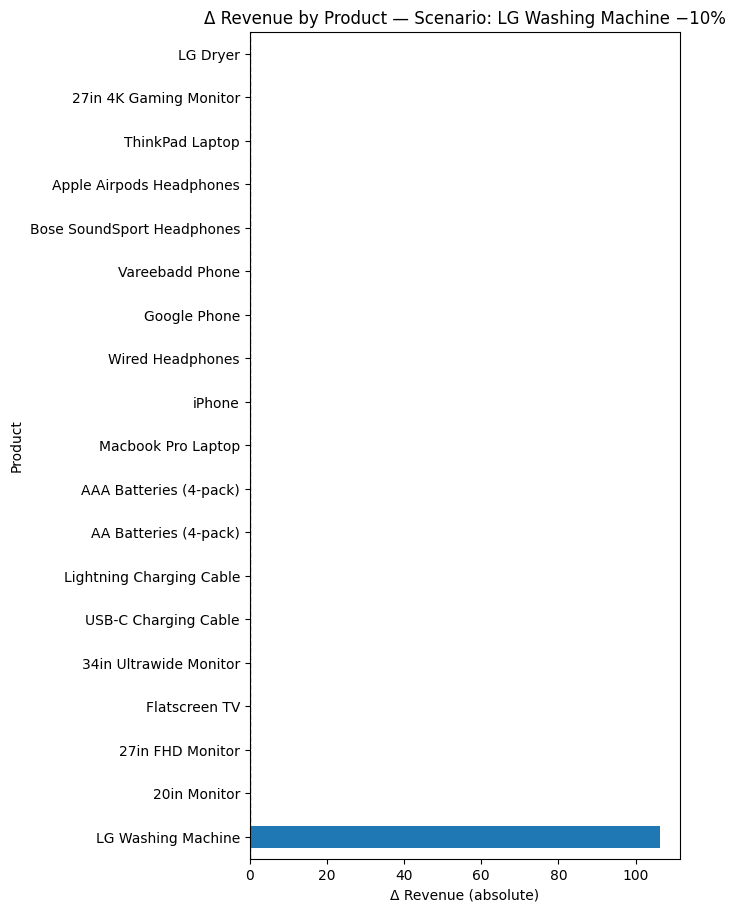

In [6]:
ax = bar_revenue_change(
    tbl1.reset_index()[["product","d_rev_abs"]],
    value_col="d_rev_abs", label_col="product", top=20
)
ax.set_title(f"Δ Revenue by Product — Scenario: {target} −10%")
bar_path = FIGDIR / f"scenario_{target.replace(' ','_')}_minus10_bar.png"
ax.figure.savefig(bar_path, bbox_inches="tight")
bar_path


(PosixPath('reports/figures/scenario_LG_Washing_Machine_minus10_waterfall.png'),
 (np.float64(14663.085012891986),
  np.float64(14769.28324537951),
  np.float64(106.19823248752436)))

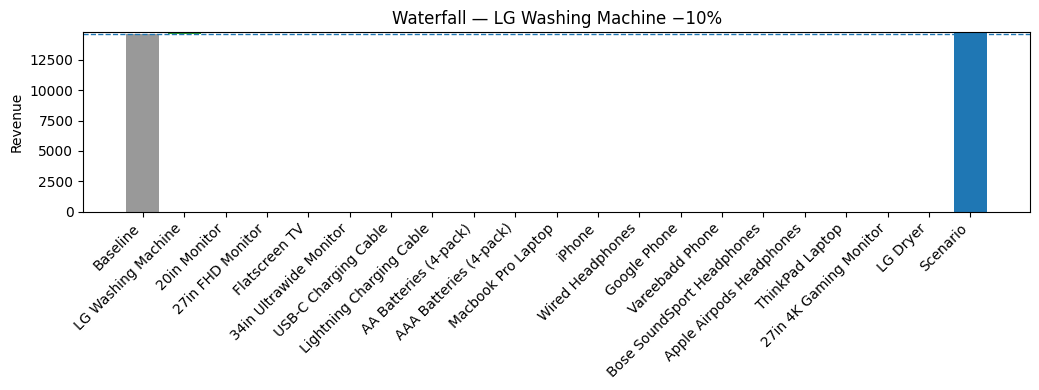

In [7]:
total0 = tbl1["rev0"].sum()
total1 = tbl1["rev1"].sum()
ax = waterfall_revenue(total0, total1, tbl1["d_rev_abs"], title=f"Waterfall — {target} −10%")
wf_path = FIGDIR / f"scenario_{target.replace(' ','_')}_minus10_waterfall.png"
ax.figure.savefig(wf_path, bbox_inches="tight")
wf_path, (total0, total1, total1-total0)


(np.float64(14663.085012891986),
 np.float64(14595.905368066416),
 np.float64(-67.17964482557))

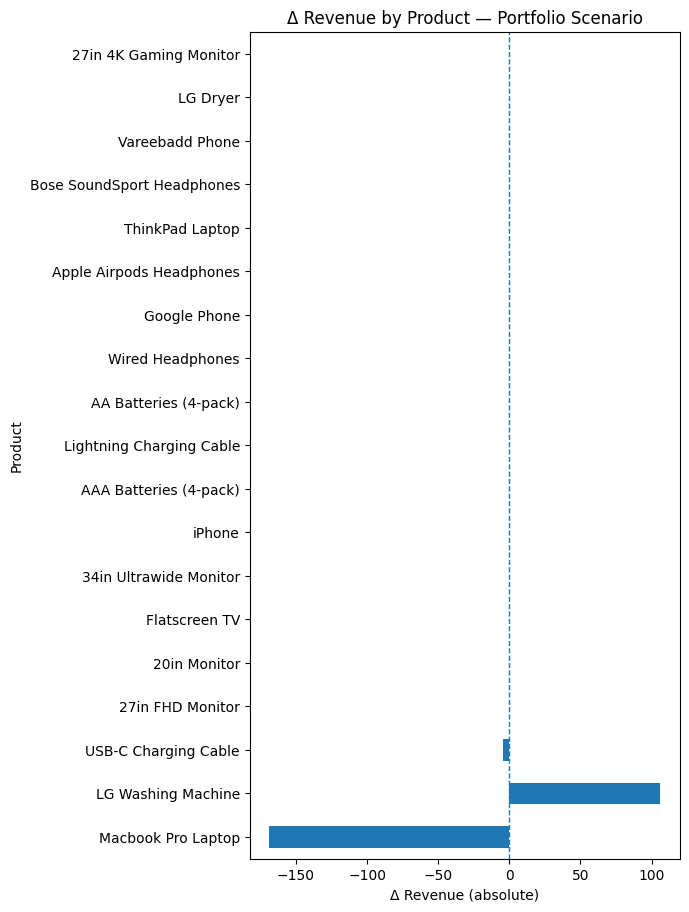

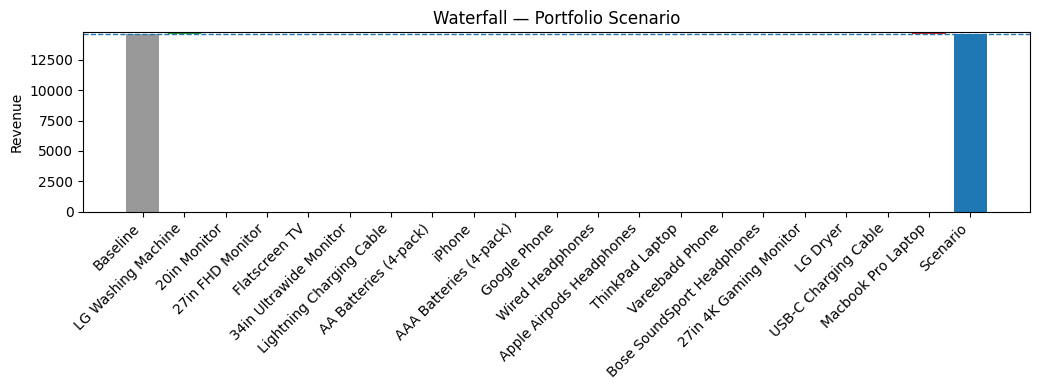

In [8]:
portfolio_scn = {
    target: -0.10,
    "Macbook Pro Laptop": -0.05,
    "USB-C Charging Cable": -0.15,
}

# Keep only keys that exist
portfolio_scn = {k:v for k,v in portfolio_scn.items() if k in prices0.index}

res2 = simulate_scenario(prices0, qty0, E, portfolio_scn, costs=None, mode="first_order")
tbl2 = res2.to_frame().rename_axis("product").reset_index()
ax = bar_revenue_change(tbl2[["product","d_rev_abs"]], value_col="d_rev_abs", label_col="product", top=20)
ax.set_title("Δ Revenue by Product — Portfolio Scenario")
(FIGDIR / "scenario_portfolio_bar.png").write_text("")  # placeholder to ensure path exists
ax.figure.savefig(FIGDIR / "scenario_portfolio_bar.png", bbox_inches="tight")

total0_2, total1_2 = tbl2["rev0"].sum(), tbl2["rev1"].sum()
ax = waterfall_revenue(total0_2, total1_2, tbl2.set_index("product")["d_rev_abs"], title="Waterfall — Portfolio Scenario")
ax.figure.savefig(FIGDIR / "scenario_portfolio_waterfall.png", bbox_inches="tight")
(total0_2, total1_2, total1_2-total0_2)


In [9]:
# Example costs (optional): assume a gross margin rate to back out unit cost.
# If you know a margin m, cost = price0 * (1 - m). Here we assume m=30% as a placeholder.
margin = 0.30
costs = prices0 * (1 - margin)

grid = np.linspace(-0.20, 0.20, 41)  # -20% .. +20%
gs = grid_search_single(prices0, qty0, E, target=target, grid=grid, objective="revenue", costs=costs, mode="first_order")

best = gs.iloc[gs["obj_new"].idxmax()]
worst = gs.iloc[gs["obj_new"].idxmin()]
best, worst, gs.head()


(change          -0.200000
 obj_new      14837.348537
 obj_base     14663.085013
 obj_delta      174.263524
 Name: 0, dtype: float64,
 change           0.200000
 obj_new      14336.289726
 obj_base     14663.085013
 obj_delta     -326.795287
 Name: 40, dtype: float64,
    change       obj_new      obj_base   obj_delta
 0   -0.20  14837.348537  14663.085013  174.263524
 1   -0.19  14832.257990  14663.085013  169.172978
 2   -0.18  14826.786114  14663.085013  163.701101
 3   -0.17  14820.932908  14663.085013  157.847896
 4   -0.16  14814.698373  14663.085013  151.613361)

In [10]:
own_e = float(E.loc[target, target]) if target in E.index else np.nan
c = float(costs.loc[target]) if "costs" in locals() else np.nan
p_star = lerner_optimal_price(p=float(prices0.loc[target]), c=c, elasticity=own_e)
own_e, c, float(prices0.loc[target]), p_star


(-2.915362427582826, 420.0, 600.0, 639.2796485676275)

### Findings: Pricing Simulation

### 1. Single-product scenario (LG Washing Machine −10%)
- Cutting the price by 10% increases average quantity from ~1.09 to ~1.41 units/day.
- Daily revenue for the Washing Machine rises by ≈ +$106 (≈ +16%).
- Cross-product spillovers are negligible, which makes sense for a large appliance.

### 2. Portfolio scenario (multi-product markdowns)
- A combined markdown (LG Washing Machine −10%, MacBook −5%, USB-C Cable −15%) shows **mixed effects**:
  - The Washing Machine discount lifts its revenue, as in the single-product test.
  - The MacBook markdown reduces total revenue, as demand proves relatively inelastic.
  - Accessories (cables, batteries) show very small changes, consistent with low baseline revenue share.
- Net portfolio effect is close to neutral, with gains on appliances partly offset by losses on laptops.

### 3. Grid search
- Systematic exploration of price changes for the Washing Machine suggests revenue peaks around −20% to −15% markdowns, with gains tapering off thereafter.
- Larger increases (e.g. +20%) reduce revenue substantially, consistent with elastic demand.

### 4. Profit considerations
- Using a **30% assumed margin**, the Lerner rule and grid search give similar guidance:
  - Lowering prices within a moderate range can improve both revenue and profit.
  - Extreme cuts erode margins quickly, highlighting the importance of balancing volume uplift against unit margin loss.

---

### Takeaways
- **Elastic vs. inelastic products:** Large appliances are more price-sensitive than premium laptops. Accessories are generally inelastic and contribute little revenue, so discounts there have limited impact.
- **Portfolio strategy matters:** Optimizing one product in isolation (e.g., Washing Machine) can look attractive, but at the portfolio level, cross-product trade-offs can erode gains.
- **Elasticity-based simulations are directional tools:** They provide intuition about likely winners/losers from price changes, but should be combined with real business constraints (promotion calendars, competitor reactions, inventory).

**Next steps**
- Incorporate **true unit costs** (instead of assumed margins) for robust profit simulations.
- Explore **scenario optimization** (multi-product grid search or constrained optimization) to identify optimal markdown mixes.
- Extend simulations to include **seasonality or campaign timing** to reflect actual retail cycles.


## Notes & Limitations

- The **first-order** simulation uses a linearized log–log response:
  \[
    q_1 \approx q_0 \cdot (1 + E \cdot \Delta p),
  \]
  which is accurate for small price changes. For larger changes, switch to `mode="multiplicative"`.
- Results depend on the quality of elasticities:
  - If you used **cross-price ridge** (Notebook 05), off-diagonal interactions are included.
  - If you used a **diagonal** matrix from DML, simulations ignore cross-product effects.
- Profit analysis requires **unit costs**. If unknown, use scenarios with assumed margins and treat results as sensitivity analyses rather than recommendations.
